In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

# Define the GRU-based model with dropout to reduce overfitting
class EEG_GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(EEG_GRU_Model, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Get the last time step output
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Convert datasets to PyTorch tensors
xtrain_gru_tensor = torch.tensor(xtrain_gru, dtype=torch.float32)
ytrain_gru_tensor = torch.tensor(ytrain_gru, dtype=torch.long)
xval_gru_tensor = torch.tensor(xval_gru, dtype=torch.float32)
yval_gru_tensor = torch.tensor(yval_gru, dtype=torch.long)

# Compute class weights to address class imbalance
classes = np.array([0, 1, 2])  # Class labels
class_weights = compute_class_weight('balanced', classes=classes, y=ytrain_gru)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Hyperparameters
input_size = xtrain_gru.shape[2]  # Number of features (4097 in your case)
hidden_size = 128  # Increased hidden size
num_layers = 3  # Increased number of layers
num_classes = 3  # Number of classes (Normal, Seizure, Epilepsy Without Seizure)
learning_rate = 0.001
num_epochs = 30
batch_size = 64  # Adding batch size for DataLoader

# Initialize the model, loss function, and optimizer
model = EEG_GRU_Model(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Apply class weights
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for batching
train_data = TensorDataset(xtrain_gru_tensor, ytrain_gru_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(xval_gru_tensor, yval_gru_tensor)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)

# Training loop with early stopping
best_val_acc = 0
early_stop_counter = 0
patience = 5  # Early stopping patience

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for data, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Validation step
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    train_acc = correct_train / total_train
    val_acc = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Learning rate scheduler step
    scheduler.step()

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_gru_eeg_model.pth')  # Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_gru_eeg_model.pth'))

# Evaluate the model on validation data
model.eval()
with torch.no_grad():
    val_outputs = model(xval_gru_tensor)
    _, val_predicted = torch.max(val_outputs, 1)

# Confusion Matrix
cm = confusion_matrix(yval_gru_tensor.numpy(), val_predicted.numpy())
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(yval_gru_tensor.numpy(), val_predicted.numpy(), target_names=["Normal", "Seizure", "Epilepsy Without Seizure"])
print("Classification Report:")
print(report)

# Validation accuracy
val_accuracy = (val_predicted == yval_gru_tensor).float().mean()
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Epoch [1/30], Loss: 1.0894, Train Acc: 0.4050, Val Acc: 0.4700
Epoch [2/30], Loss: 1.0605, Train Acc: 0.5325, Val Acc: 0.6000
Epoch [3/30], Loss: 0.9995, Train Acc: 0.6425, Val Acc: 0.6800
Epoch [4/30], Loss: 0.8840, Train Acc: 0.7400, Val Acc: 0.6500
Epoch [5/30], Loss: 0.6717, Train Acc: 0.7900, Val Acc: 0.7000
Epoch [6/30], Loss: 0.5303, Train Acc: 0.8400, Val Acc: 0.6900
Epoch [7/30], Loss: 0.4340, Train Acc: 0.8750, Val Acc: 0.7000
Epoch [8/30], Loss: 0.3429, Train Acc: 0.8875, Val Acc: 0.6900
Epoch [9/30], Loss: 0.2425, Train Acc: 0.9425, Val Acc: 0.7200
Epoch [10/30], Loss: 0.1609, Train Acc: 0.9575, Val Acc: 0.7200
Epoch [11/30], Loss: 0.1187, Train Acc: 0.9750, Val Acc: 0.6900
Epoch [12/30], Loss: 0.0806, Train Acc: 0.9800, Val Acc: 0.7100
Epoch [13/30], Loss: 0.0638, Train Acc: 0.9950, Val Acc: 0.7100
Epoch [14/30], Loss: 0.0379, Train Acc: 0.9925, Val Acc: 0.7200
Early stopping triggered. Training stopped.
Confusion Matrix:
[[31  0  9]
 [ 3  9  8]
 [ 8  0 32]]
Classification

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Check for CUDA (GPU) availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the LSTM model class
class EEG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Hyperparameters
input_size = 4097  # Number of features (EEG length)
hidden_size = 64  # Number of hidden units in LSTM
num_layers = 2  # Number of LSTM layers
num_classes = 3  # Number of output classes (Normal, Seizure, Epilepsy Without Seizure)
num_epochs = 30  # Number of epochs for training
batch_size = 32  # Batch size
learning_rate = 0.001  # Learning rate

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(ytrain_gru), y=ytrain_gru)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Create DataLoader for training and validation sets
train_data = TensorDataset(torch.tensor(xtrain_gru, dtype=torch.float32), torch.tensor(ytrain_gru, dtype=torch.long))
val_data = TensorDataset(torch.tensor(xval_gru, dtype=torch.float32), torch.tensor(yval_gru, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Initialize the LSTM model
model = EEG_LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping parameters
best_val_acc = 0
patience = 5  # Stop after 5 epochs with no improvement
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        running_loss += loss.item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'lstm_best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load the best model
model.load_state_dict(torch.load('lstm_best_model.pth'))

# Evaluate on the validation set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Normal", "Seizure", "Epilepsy Without Seizure"])

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Validation accuracy
val_accuracy = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/30, Train Loss: 1.0915, Train Accuracy: 40.25%, Val Loss: 1.0969, Val Accuracy: 41.00%
Epoch 2/30, Train Loss: 1.0297, Train Accuracy: 49.75%, Val Loss: 1.0672, Val Accuracy: 43.00%
Epoch 3/30, Train Loss: 0.9161, Train Accuracy: 84.75%, Val Loss: 1.0067, Val Accuracy: 67.00%
Epoch 4/30, Train Loss: 0.7312, Train Accuracy: 94.25%, Val Loss: 0.9361, Val Accuracy: 73.00%
Epoch 5/30, Train Loss: 0.5061, Train Accuracy: 96.25%, Val Loss: 0.8766, Val Accuracy: 73.00%
Epoch 6/30, Train Loss: 0.3041, Train Accuracy: 99.00%, Val Loss: 0.8487, Val Accuracy: 71.00%
Epoch 7/30, Train Loss: 0.1711, Train Accuracy: 99.25%, Val Loss: 0.8580, Val Accuracy: 71.00%
Epoch 8/30, Train Loss: 0.0960, Train Accuracy: 99.75%, Val Loss: 0.8974, Val Accuracy: 71.00%
Epoch 9/30, Train Loss: 0.0666, Train Accuracy: 100.00%, Val Loss: 0.9379, Val Accuracy: 68.00%
Early stopping triggered at epoch 9
Confusion Matrix:
[[32  0  8]
 [ 4  9  7]
 [ 8  0 32]]

Classification Report:
                          pre

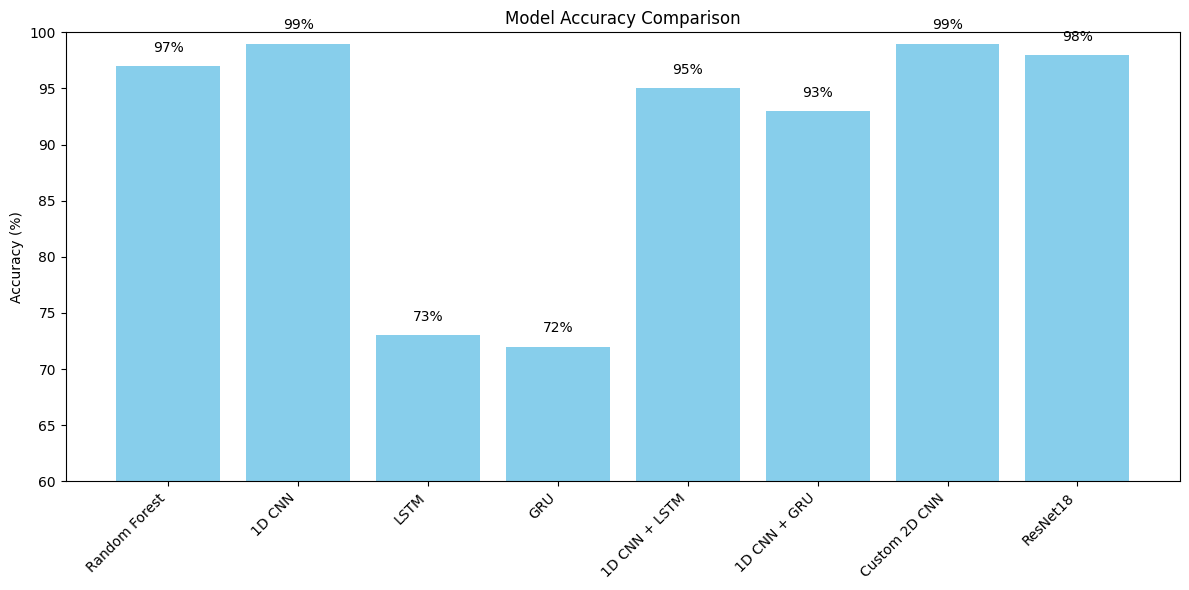

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = [
    "Random Forest",
    "1D CNN",
    "LSTM",
    "GRU",
    "1D CNN + LSTM",
    "1D CNN + GRU",
    "Custom 2D CNN",
    "ResNet18"
]

# Corresponding accuracies
accuracies = [97, 99, 73, 72, 95, 93, 99, 98]

# Create bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracies, color='skyblue')
plt.ylim(60, 100)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45, ha='right')

# Annotate accuracy values on top of each bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{acc}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()
